A brief code-based intro to recommender systems
====

This follows chapter 2 of "Programming Collective Intelligence", by T. Segaran (great book), first transcribed and adapted for the Computational Methods for Information Science Research class by Paul Ginsparg, and further by me first for that class and now for this one.

Our first order of business is to access a bunch of useful statistical and scientific computing libraries.

In [34]:
%pylab inline
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


Now, let's create a "database" of users, items, and ratings.  In a real app this would come from an actual database, but it's generally smart to develop and test on toy, tiny datasets: you can check your answers, do exploration easily, run algorithms quickly.

In [35]:
critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 
 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 
 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0, 
 'You, Me and Dupree': 3.5}, 
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0, 
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0}, 
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

Note that we have created a relatively dense database for illustration; in practice, the database is usually very sparse.

In [36]:
len(critics), map(len,critics.values())

(7, [5, 6, 5, 6, 3, 6, 4])

In [37]:
critics['Toby']

{'Snakes on a Plane': 4.5, 'Superman Returns': 4.0, 'You, Me and Dupree': 1.0}

Let's set up the mathematical intuition by looking at a world with only two movies, and thinking about what it means for two users to be similar.

In [38]:
dupree='You, Me and Dupree'
snakes='Snakes on a Plane'
ds={c.split()[-1]:(critics[c][dupree],critics[c][snakes])
    for c in critics if dupree in critics[c] and snakes in critics[c]}
ds

{'LaSalle': (2.0, 4.0),
 'Matthews': (3.5, 4.0),
 'Puig': (2.5, 3.5),
 'Rose': (2.5, 3.5),
 'Seymour': (3.5, 3.5),
 'Toby': (1.0, 4.5)}

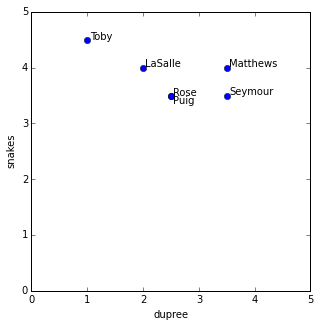

In [39]:
#now plot them
figure(figsize=(5,5))
xlim(0,5)
ylim(0,5)
offset={c:.01 for c in ds}
offset['Rose']=0
offset['Puig']=-.15 #move Puig down to avoid collision
plot([ds[crit][0] for crit in ds],[ds[crit][1] for crit in ds],'o')
for crit in ds: text(ds[crit][0]+.05,ds[crit][1]+offset[crit],crit)
xlabel('dupree')
ylabel('snakes');

Computing similarity
----

Euclidian distance says "points near each other in the space are similar", using what is essentially the Pythagorean theorem (but, instead of triangles in a 2-D space, it computes it in a space where there's one dimension for every movie in common). 

In [40]:
def sim_distance(prefs,person1,person2):
    # Get the list of shared_items
    si=[item for item in prefs[person1] if item in prefs[person2]]

    # if they have no ratings in common, return 0
    if len(si)==0: return 0
    
    v1=array([prefs[person1][item] for item in si])
    v2=array([prefs[person2][item] for item in si])

    # use numpy euclidean distance (sqrt(sum of squares))
    dist=norm(v1-v2)

    #transform to similarity ranging from 0 to 1
    simd = 1/(1+dist**2) 
    
    # We can also penalize matches based on small amounts of data.
    # if len(si) < 25: simd = simd * (min(25, len(si)) / 25.0) 
    
    # Truncate to three decimal places
    return float("%.3f"%simd)

Note that when we compute the similarity between Lisa and Claudia, it's not 1 -- because they have other movies in common besides just Snakes and Dupree.  If we _only_ had those two, the similarity would have been 1 because the distance was zero.

In [41]:
sim_distance(critics,'Lisa Rose','Claudia Puig')

0.286

A different notion of similarity, based on Pearson correlation: people are similar if their pattern of rating is the same, even if they use different scales.

In [42]:
#[+1 if correlated, -1 if anticorrelated]
def show_pearson(prefs,c1,c2):
    si=[item for item in prefs[c1] if item in prefs[c2]]

    figure(figsize=(5,5))
    xlim(0,5)
    ylim(0,5)
    xdata = [prefs[c1][item] for item in si]
    ydata = [prefs[c2][item] for item in si]

    slope, intercept, r_value, p_value, std_err = stats.linregress(xdata,ydata)
    print 'pearson r =', '%.2f'%r_value

    xlabel(c1)
    ylabel(c2)
    
    plot(xdata,ydata,'o')
    plot(slope*array(range(0,6))+intercept,'--')
    for item in si:
        text(prefs[c1][item],prefs[c2][item],item)

pearson r = 0.99
pearson r = 0.57
pearson r = 0.41
pearson r = -1.00


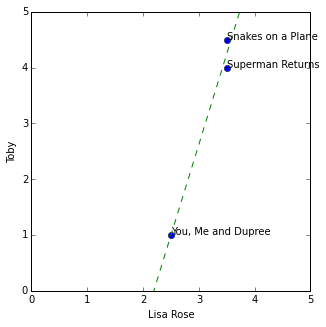

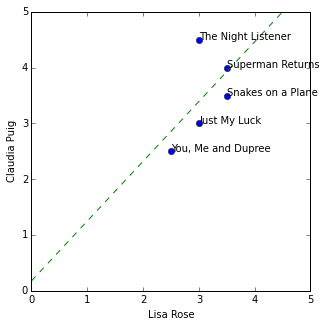

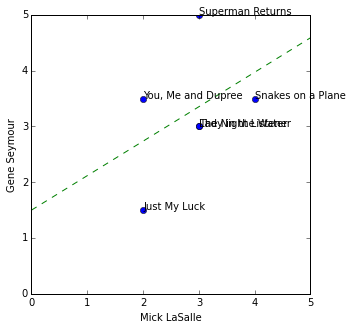

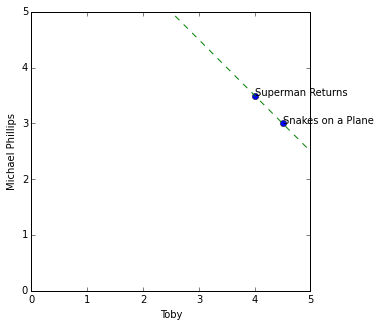

In [43]:
show_pearson(critics,'Lisa Rose','Toby')
show_pearson(critics,'Lisa Rose','Claudia Puig')
show_pearson(critics,'Mick LaSalle','Gene Seymour')
show_pearson(critics,'Toby','Michael Phillips')

In [44]:
#now define similarity measure, analogous to sim_distance
def sim_pearson(prefs,c1,c2):
    si=[item for item in prefs[c1] if item in prefs[c2]]
    if len(si)==0: return 0
    xdata = [prefs[c1][item] for item in si]
    ydata = [prefs[c2][item] for item in si]
    r,p=stats.pearsonr(xdata,ydata)
    if isnan(r): return 0
    
    # We can also penalize matches based on small amounts of data.
    # if len(si) < 25: r = r * (min(25, len(si)) / 25.0) 
    return float("%.3f"%r)

Finding neighbors
--------
And now we're ready to do some user-user recommendations.  We first find the "closest neighbors" in the database, the most similar ones, along with their similarity score.

In [45]:
# Returns the best matches for person from the prefs dictionary. 
# Number of results and similarity function are optional params.
def topMatches(prefs, person, n=5, similarity=sim_pearson):
  scores=[(other, similarity(prefs,person,other))
                  for other in prefs if other!=person]
  return sorted(scores,key=lambda x:x[1],reverse=True)[:n]

Who are Toby's neighbors?  And could we use this to recommend, e.g., people to follow in Twitter?  

In [46]:
topMatches(critics,'Toby',n=6)

[('Lisa Rose', 0.991),
 ('Mick LaSalle', 0.924),
 ('Claudia Puig', 0.893),
 ('Jack Matthews', 0.663),
 ('Gene Seymour', 0.381),
 ('Michael Phillips', -1.0)]

Note that with the Euclidian distance metric below, things are quite different, both in terms of order and relative weights (notice, in particular, Michael Phillips: the numerical ratings are quite close to each other for both the movies Toby and Michael have in common, so Euclidian and cosine would see them as "similar", whereas Pearson sees it as when Toby likes something more, Michael likes it less). 

Distance metrics (and recommendation algorithms) can give pretty different results, depending on the data that's there and the assumptions of the metric/algorithm.  One moral of the story is that this kind of modeling/machine learning work often empirically tries a number of metrics and algorithms to find one that "works best" in a given dataset.

In [47]:
topMatches(critics,'Toby', n=6, similarity=sim_distance)

[('Mick LaSalle', 0.308),
 ('Michael Phillips', 0.286),
 ('Claudia Puig', 0.235),
 ('Lisa Rose', 0.222),
 ('Jack Matthews', 0.118),
 ('Gene Seymour', 0.108)]

Making the recommendations
----
Once you have the neighbors, you can combine their ratings for movies our target user hasn't seen, weighting their opinions by how similar they are to the target user.

In [48]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings
def getRecommendations(prefs,person,similarity=sim_pearson):
  totals={}
  simSums={}
  for other in prefs:
    # don't compare me to myself
    if other==person: continue
    
    # ignore scores of zero or lower -- could have a different cutoff
    sim=similarity(prefs,person,other)
    if sim<=0: continue

    for item in prefs[other]:
      # only score movies I haven't seen yet
      if item not in prefs[person] or prefs[person][item]==0:
        if item not in totals:
            totals[item]=0
            simSums[item]=0
        # Compute the weighted rating and accumulate the weights.
        simSums[item] += sim
        totals[item] += prefs[other][item]*sim
        
        # If you wanted to do what the slides do and normalize against
        # each person's average, that would look like this.  It's slow
        # unless you cache the averages.
        # Note that you'd also have to add back in the target user's
        # average when creating the normalized list below.
        #totals[item] += (prefs[other][item] - average(prefs[other].values())) * sim 

  # Create the normalized list
  rankings=[(item,float("%.3f"%(totals[item]/simSums[item]))) for item in totals]

  # Return the sorted list
  return sorted(rankings,key=lambda x:x[1],reverse=True)

What should Toby watch?

In [49]:
getRecommendations(critics,'Toby')

[('The Night Listener', 3.348),
 ('Lady in the Water', 2.833),
 ('Just My Luck', 2.531)]

In [50]:
#or use other distance measure
getRecommendations(critics,'Toby',similarity=sim_distance)

[('The Night Listener', 3.5),
 ('Lady in the Water', 2.756),
 ('Just My Luck', 2.462)]

And now, questions, then back to the slides for a bit.  Then...

Item-item recommendations
====


Now let's look at it from an item-item perspective (i.e., "people who have bought X also bought Y" from Amazon).  The straightforward way to do this is to just flip the matrix so that items are on the rows and users are the columns; then we can use the same machinery we've been using.

In [51]:
#first reverse role of items and objects
def transformPrefs(prefs):
  result={}
  for person in prefs:
    for item in prefs[person]:
      if item not in result: result[item]={}
      
      # Flip item and person
      result[item][person]=prefs[person][item]
  return result

In [52]:
movies=transformPrefs(critics)
movies

{'Just My Luck': {'Claudia Puig': 3.0,
  'Gene Seymour': 1.5,
  'Lisa Rose': 3.0,
  'Mick LaSalle': 2.0},
 'Lady in the Water': {'Gene Seymour': 3.0,
  'Jack Matthews': 3.0,
  'Lisa Rose': 2.5,
  'Michael Phillips': 2.5,
  'Mick LaSalle': 3.0},
 'Snakes on a Plane': {'Claudia Puig': 3.5,
  'Gene Seymour': 3.5,
  'Jack Matthews': 4.0,
  'Lisa Rose': 3.5,
  'Michael Phillips': 3.0,
  'Mick LaSalle': 4.0,
  'Toby': 4.5},
 'Superman Returns': {'Claudia Puig': 4.0,
  'Gene Seymour': 5.0,
  'Jack Matthews': 5.0,
  'Lisa Rose': 3.5,
  'Michael Phillips': 3.5,
  'Mick LaSalle': 3.0,
  'Toby': 4.0},
 'The Night Listener': {'Claudia Puig': 4.5,
  'Gene Seymour': 3.0,
  'Jack Matthews': 3.0,
  'Lisa Rose': 3.0,
  'Michael Phillips': 4.0,
  'Mick LaSalle': 3.0},
 'You, Me and Dupree': {'Claudia Puig': 2.5,
  'Gene Seymour': 3.5,
  'Jack Matthews': 3.5,
  'Lisa Rose': 2.5,
  'Mick LaSalle': 2.0,
  'Toby': 1.0}}

Now topmatches gives similar movies rather than similar reviewers, and so it's _exactly_ "People who liked Superman Returns also liked X".


In [53]:
topMatches(movies,'Superman Returns')

[('You, Me and Dupree', 0.658),
 ('Lady in the Water', 0.488),
 ('Snakes on a Plane', 0.112),
 ('The Night Listener', -0.18),
 ('Just My Luck', -0.423)]

And instead of recommending movies to people, you can "recommend" people to movies.  This might be fun for marketing, for instance: you might want to give 100 free tickets to the people who are likely to like the movie the most (and thus, rate it, tell their friends, and spread the word).

In [54]:
getRecommendations(movies,'Just My Luck')

[('Michael Phillips', 4.0), ('Jack Matthews', 3.0)]

Building a model
----
So far, our code computes all the similarities on the fly, every time you want recommendations.  This is called a "memory-based" approach to recommending and becomes really expensive for a large dataset.  There are ad-hoc ways to reduce these costs (for instance, you might only maintain a fraction of your users in memory as candidate "neighbors"), but an alterative way is to build a similarity model ("model-based" approach) by pre-computing the similarities.

Typically when you do this, you build the model by pre-computing the similarity between items rather than between users; items' profiles change more slowly than users' profiles, and there are often fewer items than users, and both make item similarities more useful.  

In [55]:
def calculateSimilarItems(prefs,n=10):
  # Create a dictionary of items showing which other items they are most similar to.
  result={}
  # Invert the preference matrix to be item-centric
  itemPrefs=transformPrefs(prefs)
  c=0
  for item in itemPrefs:
    # Status updates for large datasets
    c+=1
    if c%100==0: print "%d / %d" % (c,len(itemPrefs))
    # Find the most similar items to this one
    scores=topMatches(itemPrefs,item,n=n,similarity=sim_distance)
    result[item]=scores
  return result

Now, essentially, we have a database of item similarities.  Again, in a "real" system we'd probably jam these into a proper database somewhere.

In [56]:
itemsim=calculateSimilarItems(critics)
itemsim

{'Just My Luck': [('Lady in the Water', 0.222),
  ('You, Me and Dupree', 0.182),
  ('The Night Listener', 0.154),
  ('Snakes on a Plane', 0.105),
  ('Superman Returns', 0.065)],
 'Lady in the Water': [('You, Me and Dupree', 0.4),
  ('The Night Listener', 0.286),
  ('Snakes on a Plane', 0.222),
  ('Just My Luck', 0.222),
  ('Superman Returns', 0.091)],
 'Snakes on a Plane': [('Lady in the Water', 0.222),
  ('The Night Listener', 0.182),
  ('Superman Returns', 0.167),
  ('Just My Luck', 0.105),
  ('You, Me and Dupree', 0.051)],
 'Superman Returns': [('Snakes on a Plane', 0.167),
  ('The Night Listener', 0.103),
  ('Lady in the Water', 0.091),
  ('Just My Luck', 0.065),
  ('You, Me and Dupree', 0.053)],
 'The Night Listener': [('Lady in the Water', 0.286),
  ('Snakes on a Plane', 0.182),
  ('Just My Luck', 0.154),
  ('You, Me and Dupree', 0.148),
  ('Superman Returns', 0.103)],
 'You, Me and Dupree': [('Lady in the Water', 0.4),
  ('Just My Luck', 0.182),
  ('The Night Listener', 0.148),


And now we can generate recommendations using the pre-computed item similarities.  Computing the item similarity matrix can take some time up front, but it becomes very fast to compute the recommendations after you build the model because instead of comparing the user to every other user, we just get the items they've rated and look up the similar items in the dataset.

In [57]:
def getRecommendedItems(prefs,itemMatch,user):
  userRatings=prefs[user]
  scores={}
  totalSim={}
  # Loop over items rated by this user
  for (item,rating) in userRatings.items( ):

    # Loop over items similar to this one
    for (item2,similarity) in itemMatch[item]:
      # Ignore if this user has already rated this item
      if item2 in userRatings: continue
      # Weighted sum of rating times similarity
      if item2 not in scores:
          scores[item2]=0
          totalSim[item2]=0
      scores[item2]+=similarity*rating
      # Sum of all the similarities
      totalSim[item2]+=similarity

  # Divide each total score by total weighting to get an average
  rankings=[(item,float("%.3f"%(scores[item]/totalSim[item]))) for item in scores]

  return sorted(rankings,key=lambda x:x[1],reverse=True)

Again, the recommendations can be pretty different, because the model is different.  In general, item-item algorithms test out as a little more accurate than user-user ones in offline testing, where you "hide" some ratings from the recommender and see how close your predicted ones are to the actual ones.

In [58]:
print "User-user: ", getRecommendations(critics,'Toby',similarity=sim_distance)
print "Item-item: ", getRecommendedItems(critics,itemsim,'Toby')

User-user:  [('The Night Listener', 3.5), ('Lady in the Water', 2.756), ('Just My Luck', 2.462)]
Item-item:  [('The Night Listener', 3.185), ('Just My Luck', 2.598), ('Lady in the Water', 2.473)]


A bigger dataset
----

Finally, a quick demo of this on the smallest MovieLens ratings dataset, which was a commonly used dataset early in the history of collaborative filtering.

In [59]:
#http://www.grouplens.org/node/12
#http://www.grouplens.org/system/files/ml-100k.zip
#contains
#u.item list of movie ids and titles
#u.data ratings     user id, movie id, rating, timestamp
#stored in ml-100k/ folder

def loadMovieLens(path='ml-100k/'):
  # Get movie titles
  movies={}
  for line in open(path+'u.item'):
    (id,title)=line.split('|')[0:2]
    movies[id]=title
  
  # Load data
  prefs={}
  for line in open(path+'u.data'):
    (user,movieid,rating,ts)=line.split('\t')
    if user not in prefs: prefs[user]={}
    prefs[user][movies[movieid]]=float(rating)
  return prefs

In [60]:
mprefs=loadMovieLens()

In [61]:
len(mprefs),map(len,mprefs.values()[:10])

(943, [188, 230, 193, 198, 44, 20, 201, 236, 25, 21])

In [62]:
topMatches(transformPrefs(mprefs),'Terminator, The (1984)',n=10)

[('8 Seconds (1994)', 1.0),
 ('Calendar Girl (1993)', 1.0),
 ('Hurricane Streets (1998)', 1.0),
 ("Ed's Next Move (1996)", 1.0),
 ('Wild Reeds (1994)', 1.0),
 ('Scarlet Letter, The (1926)', 1.0),
 ('Vermin (1998)', 1.0),
 ('Outlaw, The (1943)', 1.0),
 ('Rhyme & Reason (1997)', 1.0),
 ('Beans of Egypt, Maine, The (1994)', 1.0)]

In [63]:
#get recommendations for user 87
getRecommendations(mprefs,'4')[:30]

[('Legal Deceit (1997)', 5.0),
 ('They Made Me a Criminal (1939)', 5.0),
 ("Someone Else's America (1995)", 5.0),
 ('Letter From Death Row, A (1998)', 5.0),
 ('Ballad of Narayama, The (Narayama Bushiko) (1958)', 5.0),
 ('Saint of Fort Washington, The (1993)', 5.0),
 ('Faust (1994)', 5.0),
 ('Star Kid (1997)', 5.0),
 ('Little City (1998)', 5.0),
 ('Mina Tannenbaum (1994)', 5.0),
 ('Great Day in Harlem, A (1994)', 5.0),
 ('Sliding Doors (1998)', 5.0),
 ('Boys, Les (1997)', 5.0),
 ('Hearts and Minds (1996)', 5.0),
 ('N\xe9nette et Boni (1996)', 4.83),
 ("C'est arriv\xe9 pr\xe8s de chez vous (1992)", 4.794),
 ('Braindead (1992)', 4.709),
 ('Guantanamera (1994)', 4.686),
 ('Wrong Trousers, The (1993)', 4.652),
 ('Pather Panchali (1955)', 4.616),
 ('Magic Hour, The (1998)', 4.611),
 ('Close Shave, A (1995)', 4.582),
 ('Maya Lin: A Strong Clear Vision (1994)', 4.527),
 ('Fear of a Black Hat (1993)', 4.496),
 ('Ruling Class, The (1972)', 4.464),
 ('My Man Godfrey (1936)', 4.463),
 ('Leading Ma

In [64]:
#now item based
itemsim=calculateSimilarItems(mprefs,n=50)

100 / 1664
200 / 1664
300 / 1664
400 / 1664
500 / 1664
600 / 1664
700 / 1664
800 / 1664
900 / 1664
1000 / 1664
1100 / 1664
1200 / 1664
1300 / 1664
1400 / 1664
1500 / 1664
1600 / 1664


In [65]:
#takes a while to build, but now recommendations instantaneous, and indep
# of number of users. experiment with this dataset...
getRecommendedItems(mprefs,itemsim,'4')[:30]

[('To Cross the Rubicon (1991)', 5.0),
 ('Adventures of Pinocchio, The (1996)', 5.0),
 ('Love Affair (1994)', 5.0),
 ('Magnificent Seven, The (1954)', 5.0),
 ('Paths of Glory (1957)', 5.0),
 ('Tin Men (1987)', 5.0),
 ('Endless Summer 2, The (1994)', 5.0),
 ('Village of the Damned (1995)', 5.0),
 ('Careful (1992)', 5.0),
 ('Inventing the Abbotts (1997)', 5.0),
 ("White Man's Burden (1995)", 5.0),
 ('2 Days in the Valley (1996)', 5.0),
 ('Big Green, The (1995)', 5.0),
 ('Night Flier (1997)', 5.0),
 ('Close Shave, A (1995)', 5.0),
 ('Showgirls (1995)', 5.0),
 ("Someone Else's America (1995)", 5.0),
 ('Nadja (1994)', 5.0),
 ("C'est arriv\xe9 pr\xe8s de chez vous (1992)", 5.0),
 ('Country Life (1994)', 5.0),
 ('Milk Money (1994)', 5.0),
 ('Angel and the Badman (1947)', 5.0),
 ('Burnt Offerings (1976)', 5.0),
 ('Old Man and the Sea, The (1958)', 5.0),
 ('Flirt (1995)', 5.0),
 ('Fifth Element, The (1997)', 5.0),
 ('Heaven & Earth (1993)', 5.0),
 ('U.S. Marshalls (1998)', 5.0),
 ('Barcelona (1

In [66]:
print [(p, mprefs['4'][p]) for p in mprefs['4']]

[('Blues Brothers 2000 (1998)', 5.0), ('Liar Liar (1997)', 5.0), ('Lost Highway (1997)', 5.0), ('Mimic (1997)', 3.0), ('Air Force One (1997)', 5.0), ('Event Horizon (1997)', 4.0), ('Contact (1997)', 5.0), ('Scream (1996)', 4.0), ("One Flew Over the Cuckoo's Nest (1975)", 4.0), ('Spawn (1997)', 2.0), ("Ulee's Gold (1997)", 5.0), ('In & Out (1997)', 5.0), ('Wedding Singer, The (1998)', 5.0), ('Cop Land (1997)', 5.0), ('Starship Troopers (1997)', 4.0), ('Client, The (1994)', 3.0), ('Incognito (1997)', 5.0), ('Seven (Se7en) (1995)', 4.0), ('Wonderland (1997)', 5.0), ('Desperate Measures (1998)', 5.0), ('Conspiracy Theory (1997)', 3.0), ('Assignment, The (1997)', 5.0), ('Star Wars (1977)', 5.0), ('Indiana Jones and the Last Crusade (1989)', 3.0)]
